# Setup

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import time
import math
import wandb
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from common import transfer_functions, utils

# 1 Layer Functions

In [2]:
def Epoch(img, s, weights, biases):
    # Forward propagation input -> hidden
    h_pre = biases[0] + weights[0] @ img
    h = transfer_functions.sigmoid(h_pre)
    # Forward propagation hidden -> output
    o_pre = biases[1] + weights[1] @ h
    o = transfer_functions.sigmoid(o_pre)

    # Backpropagation output -> hidden (cost function ddverivative)
    delta_o = o - s  # cross_entropy(s, o) * o
    weights[1] += -learn_rate * delta_o @ np.transpose(h)
    biases[1] += -learn_rate * delta_o

    # Backpropagation hidden -> input (activation function derivative)
    delta_h = np.transpose(weights[1]) @ delta_o * (h * (1 - h))
    weights[0] += -learn_rate * delta_h @ np.transpose(img)
    biases[0] += -learn_rate * delta_h
    return weights, biases

In [3]:
def evaluate(img, weights, biases):

    # Forward propagation input -> hidden
    h_pre = biases[0] + weights[0] @ img
    h = transfer_functions.sigmoid(h_pre)
    # Forward propagation hidden -> output
    o_pre = biases[1] + weights[1] @ h
    o = transfer_functions.sigmoid(o_pre)

    return o

# 2 Layer functions

In [25]:
def Epoch(img, s, weights, biases):
    # Forward propagation input -> hidden
    h1_pre = biases[0] + weights[0] @ img
    h1 = transfer_functions.sigmoid(h1_pre)

    h2_pre = biases[1] + weights[1] @ h1
    h2 = transfer_functions.sigmoid(h2_pre)

    # Forward propagation hidden -> output
    o_pre = biases[2] + weights[2] @ h2
    o = transfer_functions.sigmoid(o_pre)

    # Backpropagation output -> hidden (cost function ddverivative)
    delta_o = o - s  # cross_entropy(s, o) * o
    weights[2] += -learn_rate * delta_o @ np.transpose(h2)
    biases[2] += -learn_rate * delta_o

    # Backpropagation hidden -> input (activation function derivative)
    delta_h2 = np.transpose(weights[2]) @ delta_o * (h2 * (1 - h2))
    weights[1] += -learn_rate * delta_h2 @ np.transpose(h1)
    biases[1] += -learn_rate * delta_h2

    delta_h1 = np.transpose(weights[1]) @ delta_h2 * (h1 * (1 - h1))
    weights[0] += -learn_rate * delta_h1 @ np.transpose(img)
    biases[0] += -learn_rate * delta_h1

    return weights, biases

In [26]:
def evaluate(img, weights, biases):

    # Forward propagation input -> hidden
    h1_pre = biases[0] + weights[0] @ img
    h1 = transfer_functions.sigmoid(h1_pre)

    h2_pre = biases[1] + weights[1] @ h1
    h2 = transfer_functions.sigmoid(h2_pre)

    # Forward propagation hidden -> output
    o_pre = biases[2] + weights[2] @ h2
    o = transfer_functions.sigmoid(o_pre)

    return o

# Train Model

In [27]:
dataset = "NewDataset11"
Model_name = "NewMazeTest11"

mazes, solves = utils.load_data(f"datasets/Mazes/{dataset}.pickle")

size = 11

input_layer_size = size ** 2
hidden_layer_sizes = [200, 200]
output_layer_size = size ** 2

learn_rate = 0.01
epochs = 40

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="MazeSolver",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learn_rate,
    "hidden_layer_sizes": hidden_layer_sizes,
    "dataset": dataset,
    "activation": "Sigmoid",
    "epochs": epochs,
    },
)


# weights = w, biases = b, input = i, hidden = h, output = o
# w_i_h = weights input to hidden

# Initialize layers
w_i_h1 = np.random.uniform(-0.5, 0.5, (hidden_layer_sizes[0], input_layer_size))
w_h1_h2 = np.random.uniform(-0.5, 0.5, (hidden_layer_sizes[1], hidden_layer_sizes[0]))
w_h2_o = np.random.uniform(-0.5, 0.5, (output_layer_size, hidden_layer_sizes[1]))
b_i_h1 = np.zeros((hidden_layer_sizes[0], 1))
b_h1_h2 = np.zeros((hidden_layer_sizes[1], 1))
b_h2_o = np.zeros((output_layer_size, 1))

weights = [w_i_h1, w_h1_h2, w_h2_o]
biases = [b_i_h1, b_h1_h2, b_h2_o]

'''
TODO Implement Batches

Load data into memory based off of batch number, back propogate in batches
Currently we are using batch size=1 or schotastic training. while also loading all of the data into memory
this is a less direct training approach and when moving to larger datasets will destroy our memory.

TODO convert dataset to a batchable type

TODO stop training early and still save model
'''
test_partition = 5000

for epocho in range(epochs):
    for index in range(len(mazes) - test_partition):
        img, s = mazes[index], solves[index]
        img.shape += (1,)
        s.shape += (1,)
        weights, biases = Epoch(img, s, weights, biases)
    
    factor = 10
    average_score = []
    loss = []

    for index in range(-1, -test_partition, -1):
        img, s = mazes[index], solves[index]
        img.shape += (1,)
        s.shape += (1,)
        s_pred = evaluate(img, weights, biases)
        average = 1 - abs(s - s_pred).mean()
        score = math.exp((average-1)*factor)*average
        average_score.append(score)
        loss.append(log_loss(s, s_pred))

    mean_acc = np.mean(average_score) * 100
    highest_acc = np.amax(average_score) * 100
    lowest_acc = np.amin(average_score) * 100
    mean_loss = np.mean(loss)
    wandb.log({
        "Accuracy": mean_acc,
        "Loss": mean_loss 
        })


    # Show accuracy for this epoch
    print(f"Epoch #{epocho} Mean Acc: {round(mean_acc, 3)}% Highest Acc: {round(highest_acc, 3)}% Lowest Acc: {round(lowest_acc, 3)}%")
    #print(f"Index High: {average_score.index(np.amax(average_score))} Index Low: {average_score.index(np.amin(average_score))}")

wandb.finish()
utils.store_model(f"models/Mazes/{Model_name}.pickle", weights, biases)

Epoch #0 Mean Acc: 22.162% Highest Acc: 76.956% Lowest Acc: 3.389%
Epoch #1 Mean Acc: 27.612% Highest Acc: 87.017% Lowest Acc: 3.468%
Epoch #2 Mean Acc: 34.46% Highest Acc: 95.044% Lowest Acc: 4.164%
Epoch #3 Mean Acc: 36.527% Highest Acc: 95.175% Lowest Acc: 3.305%
Epoch #4 Mean Acc: 39.665% Highest Acc: 96.31% Lowest Acc: 3.356%
Epoch #5 Mean Acc: 46.112% Highest Acc: 96.594% Lowest Acc: 4.53%
Epoch #6 Mean Acc: 47.451% Highest Acc: 98.71% Lowest Acc: 4.318%
Epoch #7 Mean Acc: 49.281% Highest Acc: 98.97% Lowest Acc: 3.835%
Epoch #8 Mean Acc: 51.928% Highest Acc: 99.441% Lowest Acc: 4.318%
Epoch #9 Mean Acc: 50.43% Highest Acc: 98.792% Lowest Acc: 5.05%
Epoch #10 Mean Acc: 55.439% Highest Acc: 99.098% Lowest Acc: 3.042%
Epoch #11 Mean Acc: 54.403% Highest Acc: 99.091% Lowest Acc: 3.942%
Epoch #12 Mean Acc: 60.548% Highest Acc: 99.389% Lowest Acc: 3.039%
Epoch #13 Mean Acc: 58.146% Highest Acc: 99.599% Lowest Acc: 4.503%
Epoch #14 Mean Acc: 58.602% Highest Acc: 99.404% Lowest Acc: 4.41

Accuracy,▁▂▃▃▄▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇██▇▇██▇█▇▇███▇▇▇▇██
Loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▂▂▂▁▂▁▂▂▁▁▁▂▂▂▂▂▁
Accuracy,65.7558
Loss,0.08942


# Load Model

In [11]:
dataset = "NewDataset11"
Model_name = "NewMazeTest11"

mazes, solves = utils.load_data(f"datasets/Mazes/{dataset}.pickle")

weights, biases = utils.load_model(f"models/Mazes/{Model_name}.pickle")

# Model Testing

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0.]
30.571564057457763


<Figure size 640x480 with 0 Axes>

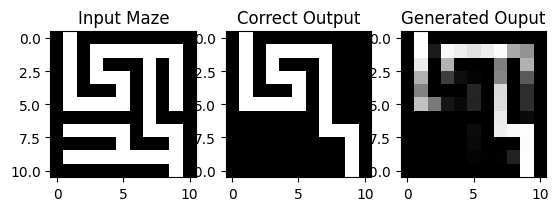

In [22]:
# Last Thousand images are not used in training
test_index = -346

# Extract Maze
maze = mazes[test_index]
solve = solves[test_index]
maze.shape += (1,)
solve.shape += (1,)


o = evaluate(img, weights, biases)


# Show Output
reshaped_maze = maze.reshape(11, 11) * 255
reshaped_solve = solve.reshape(11, 11) * 255
reshaped_o = o.reshape(11, 11) * 255


maze_img = Image.fromarray(reshaped_maze)
solve_img = Image.fromarray(reshaped_solve)
o_img = Image.fromarray(reshaped_o)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,3) 

axarr[0].title.set_text("Input Maze")
axarr[0].imshow(maze_img)
axarr[1].title.set_text("Correct Output")
axarr[1].imshow(solve_img)
axarr[2].title.set_text("Generated Ouput")
axarr[2].imshow(o_img)

average = 1 - abs(solve - o).mean()
factor = 10
score = math.exp((average-1)*factor)*average

print(score * 100)


## Removing Duplicates test

           0             1        2             3        4             5    \
count  10472.0  10472.000000  10472.0  10472.000000  10472.0  10472.000000   
mean       0.0      0.209129      0.0      0.196238      0.0      0.190604   
std        0.0      0.406706      0.0      0.397169      0.0      0.392796   
min        0.0      0.000000      0.0      0.000000      0.0      0.000000   
25%        0.0      0.000000      0.0      0.000000      0.0      0.000000   
50%        0.0      0.000000      0.0      0.000000      0.0      0.000000   
75%        0.0      0.000000      0.0      0.000000      0.0      0.000000   
max        0.0      1.000000      0.0      1.000000      0.0      1.000000   

           6             7        8             9    ...           111  \
count  10472.0  10472.000000  10472.0  10472.000000  ...  10472.000000   
mean       0.0      0.196429      0.0      0.207601  ...      0.210657   
std        0.0      0.397315      0.0      0.405609  ...      0.407795   
m

<Figure size 640x480 with 0 Axes>

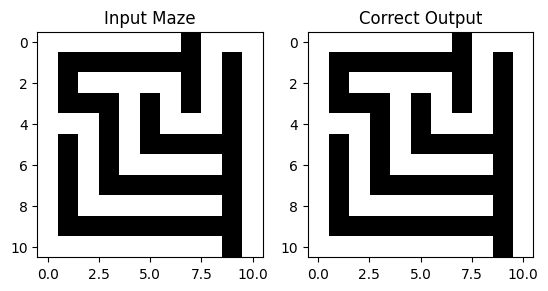

In [3]:


mazes, solves = utils.load_data(f"datasets/Mazes/NewDataset11.pickle")

mazes_df = pd.DataFrame(solves)

arr, uniq_cnt = np.unique(solves, axis=0, return_counts=True)
uniq_arr = arr[uniq_cnt>1]
same_arr = arr[uniq_cnt==1]

print(pd.DataFrame(same_arr).describe())

indicies = np.where((solves == uniq_arr[1]).all(axis=1))
print(indicies)

reshaped_maze = 255 - mazes[0].reshape(11, 11) * 255
reshaped_solve = 255 - mazes[0].reshape(11, 11) * 255
#reshaped_o = o.reshape(11, 11) * 255

maze_img = Image.fromarray(reshaped_maze)
solve_img = Image.fromarray(reshaped_solve)
#o_img = Image.fromarray(reshaped_o)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].title.set_text("Input Maze")
axarr[0].imshow(maze_img)
axarr[1].title.set_text("Correct Output")
axarr[1].imshow(solve_img)
#axarr[2].title.set_text("Generated Ouput")
#axarr[2].imshow(o_img)

<Figure size 640x480 with 0 Axes>

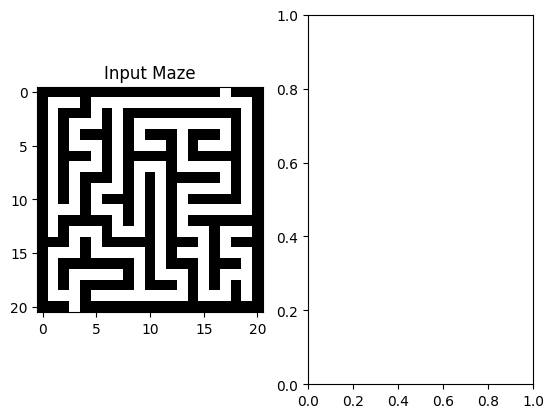

In [3]:
import pickle

with open("datasets/Mazes/NewMazeDataset21.pickle", "rb") as fin:
    mazes = pickle.load(fin)

reshaped_maze = mazes[874].reshape(21, 21) * 255
#reshaped_o = o.reshape(11, 11) * 255

maze_img = Image.fromarray(reshaped_maze)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].title.set_text("Input Maze")
axarr[0].imshow(maze_img)
